<a href="https://colab.research.google.com/github/IssamBenamara/SIFT_BOW/blob/master/TP1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/tools.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/compute_kmeans.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/compute_sifts.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/sift.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/kmeans.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/bow.py

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
from tools import *

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
!unzip /content/drive/My\ Drive/data.zip -d /content/

# Partie 1 : SIFT

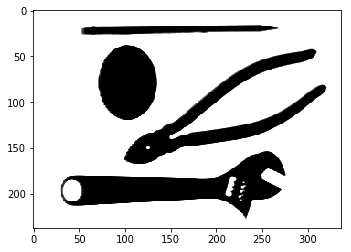

In [87]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I)

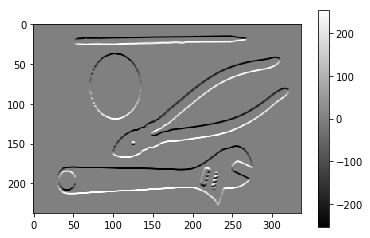

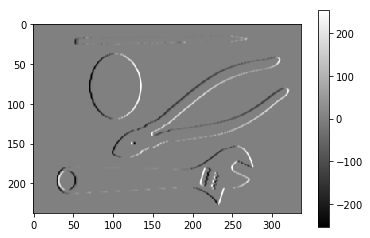

In [88]:
def compute_grad(I):
    h_x = 0.5*np.asarray([1,0,-1])
    h_y = 0.5*np.asarray([-1,-2,-1])
    Iy = conv_separable(I, h_x, h_y)
    Ix = conv_separable(I, h_y, h_x)
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [0]:
def compute_grad_mod_ori(I):
    Ix, Iy = compute_grad(I)
    Gm = np.sqrt(Ix**2+Iy**2)
    Go = compute_grad_ori(Ix, Iy, Gm)
    return Gm, Go

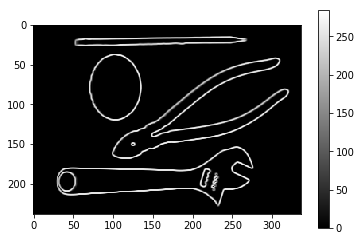

In [97]:
Gm, Go = compute_grad_mod_ori(I)
plt.imshow(Gm)
plt.colorbar()
plt.show()

In [0]:
def compute_sift_region(Gm, Go, mask=None):
    # Note: to apply the mask only when given, do:
    R = np.zeros((16,8))
    Gn = Gm.copy()
    if mask is not None:
        Gn = np.multiply(Gn, mask)
    for i in range(4):
        for j in range(4):
            Gn_region = Gn[j*4:j*4+4,i*4:i*4+4]
            Go_region = Go[j*4:j*4+4,i*4:i*4+4]

            for v in range(8):
                ind = np.where(Go_region==v)
                s = np.sum(Gn_region[ind[0],ind[1]])
                R[i*4+j][v] = s
    sift = R.ravel()
    norm = np.linalg.norm(sift)
    if norm < 0.5:
        return np.zeros(sift.shape)
    sift = sift/np.linalg.norm(sift)
    sift = np.clip(sift,0,0.2)
    sift = sift/np.linalg.norm(sift)
    return sift

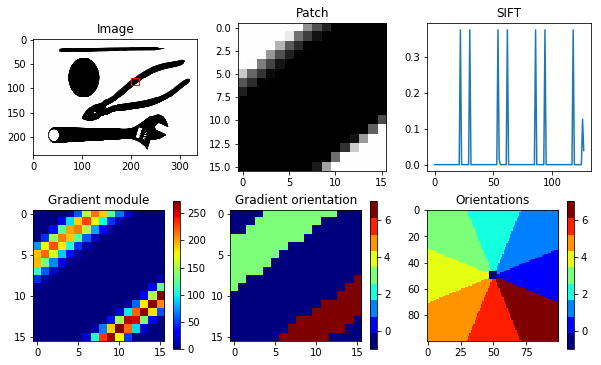

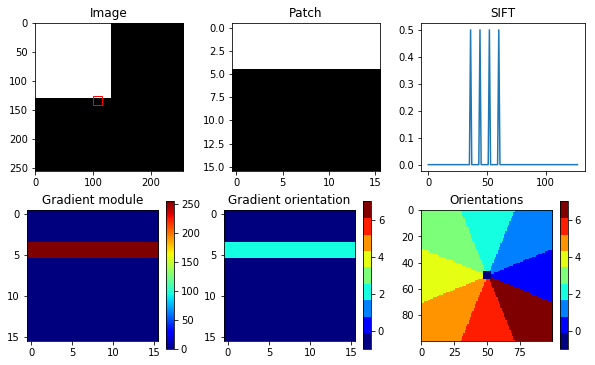

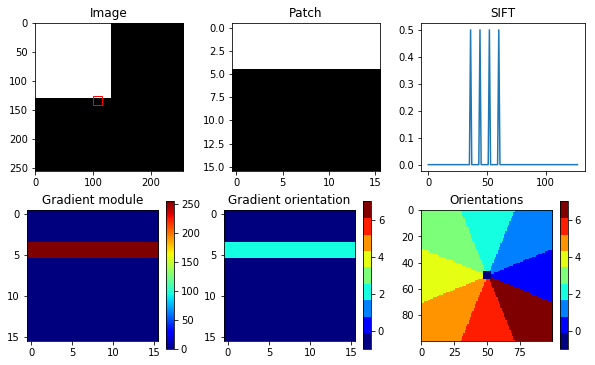

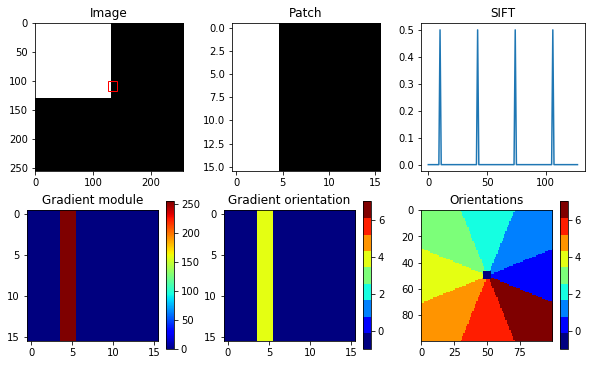

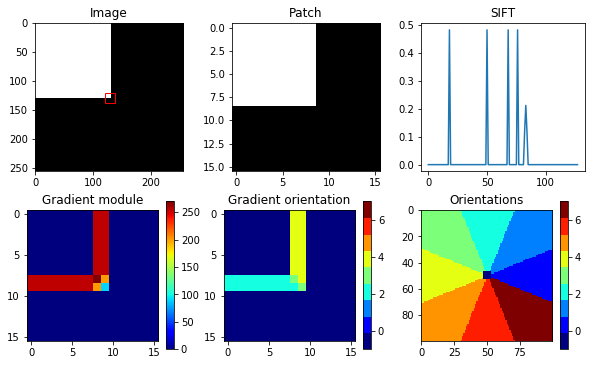

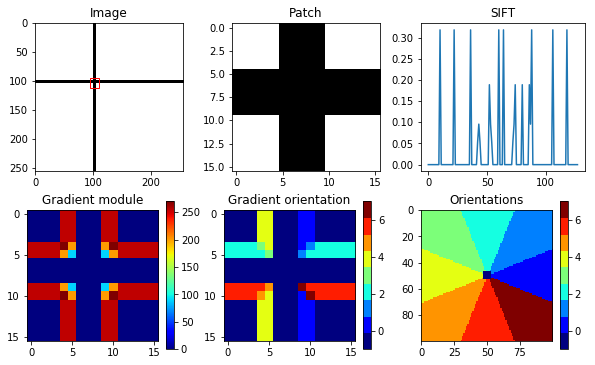

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3181317 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.3181317 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.18864812, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.3181317 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.18864

In [0]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [0]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    
    sifts = np.zeros((len(x), len(y), 128))
    Gn, Go = compute_grad_mod_ori(im)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            Gn_region = Gn[xi:xi+16,yj:yj+16]
            Go_region = Go[xi:xi+16,yj:yj+16]
            sifts[i, j, :] = compute_sift_region(Gn_region, Go_region) # TODO SIFT du patch de coordonnee (xi, yj)
    return sifts

# Partie 2 : Dictionnaire visuel

In [0]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
from tools import *
from sift import *

In [0]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift')
path_vdict = os.path.join('data', 'kmeans', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')

inames, ilabls, cnames = load_dataset(dir_sc)

In [4]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


In [0]:
# Code here the `compute_visual_dict` function
from sklearn import metrics 
from sklearn.cluster import KMeans
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    sift = sift/255

    kmeans = KMeans(n_clusters=n_clusters, n_init = n_init).fit(sift)
    cluster_centers = kmeans.cluster_centers_.tolist()
    cluster_centers.append([0]*(len(cluster_centers[0])))
    return np.asarray(cluster_centers)


In [7]:
# Run the visual dict computation (saved the first time)
vidct = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict


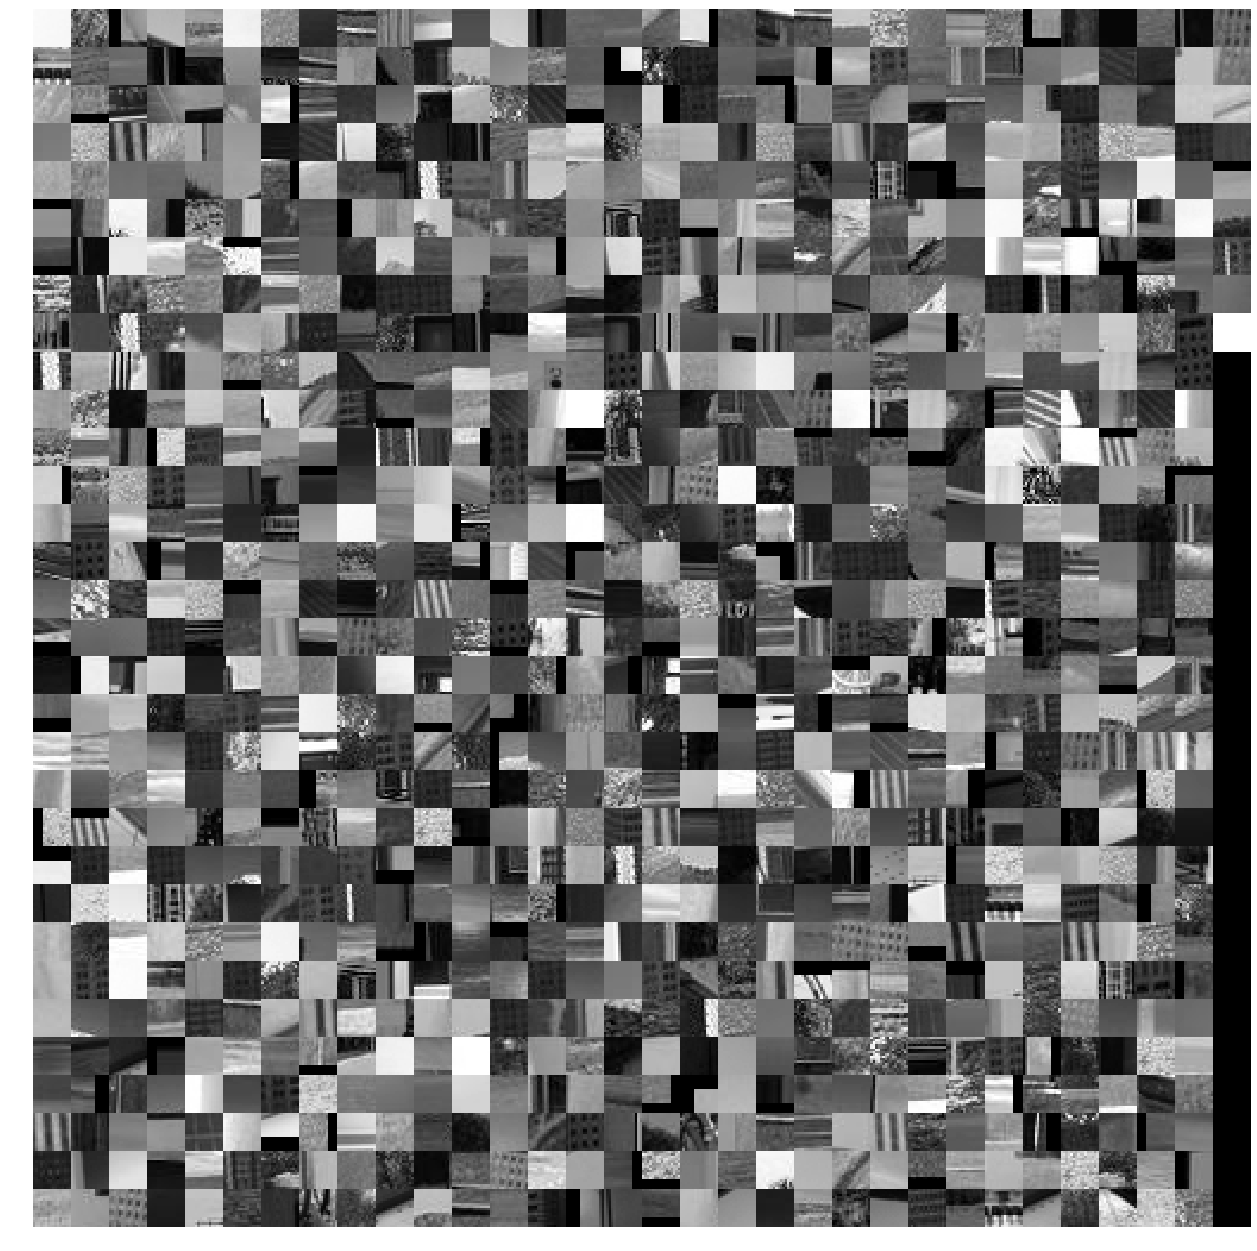

In [131]:
# Study of the dict
from scipy.spatial import distance_matrix

regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 30)) # Compute SIFT and regions from 30 random images
dm = distance_matrix(vidct,sifts)
ids = np.argmin(dm,axis=1)
display_images(regions[ids])

# TODO visually analyze the dict through similar example regions
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

In [0]:
!zip -r data.zip data

In [0]:
!mv data.zip /content/drive/My\ Drive/

In [0]:
drive.mount('/content/drive')

Mounted at /content/drive


# Partie 3 : BoW

In [0]:
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 1))

In [135]:
sifts.shape, vidct.shape

((1148, 128), (1001, 128))

In [136]:
dm = distance_matrix(sifts,vidct)
ids = np.argmin(dm,axis=1)
ids.shape

(1148,)

In [0]:
z = np.zeros(dm.shape)

In [149]:
z[range(len(ids)),ids] = 1
z

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [163]:
z.sum(axis=0).shape

(1001,)

In [0]:
# Compute BoW for an image

def compute_feats(vdict, image_sifts):
    from scipy.spatial import distance_matrix
    # TODO compute BoW from `image_sifts`
    sift = image_sifts
    sift = [s.reshape(-1, sift[0].shape[-1]) for s in sift]
    sift = np.concatenate(sift, axis=0)
    
    # Coding
    dm = distance_matrix(sift,vidct)
    ids = np.argmin(dm,axis=1)
    h = np.zeros(dm.shape)
    h[range(len(ids)),ids] = 1

    # Pooling
    z = h.sum(axis=0)
    z = z/np.linalg.norm(z)
    return z

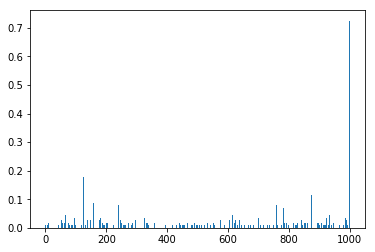

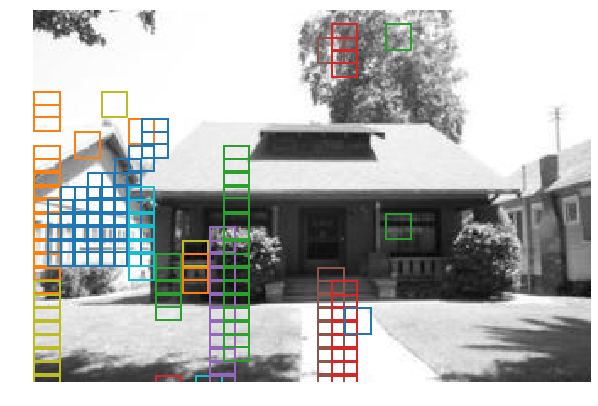

ValueError: ignored

In [10]:
# Visualize your BoW on an image
import matplotlib.pyplot as plt

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
regions = compute_regions(im)
feats = compute_feats(vidct, sift)

display_vdregions_image(im, vidct, sift, feats, vdregions=None) # if you have vdregions, add it as input here

In [173]:
sift.shape

(28, 42, 128)

In [175]:
sift = [s.reshape(-1, sift[0].shape[-1]) for s in sift]
sift = np.concatenate(sift, axis=0)
sift.shape

(1176, 128)